In [2]:
folder = "D:/users/marko/downloads/mirna/analysis"
folder2 = "D:/users/marko/downloads/mirna/models"
folder3 = "D:/users/marko/downloads/mirna/"

In [4]:
vae_code = "1vchzpq3"
beta_vae_code = "f7a8z5ga"
beta_iaf_vae_code = "1omrpwc6"
dc_beta_iaf_vae_code = "1pcu3ra0"
dc_iaf_diva = "2fh6vyi6"
codes = [vae_code, beta_vae_code, beta_iaf_vae_code, dc_beta_iaf_vae_code, dc_iaf_diva]

# library imports

In [5]:
import numpy as np
import pandas as pd
import sys 
import os 
import io
import wandb
import torch

sys.path.insert(0, folder)
sys.path.insert(0, folder2)
os.chdir(folder)

for i in codes:
    os.makedirs(f"{folder}/latspaces/{i}/", exist_ok=True)


from concepts import *
from utils import *
from model import *
from dataset import *

from tqdm import tqdm

import plotly.graph_objs as go
from ipywidgets import HTML, Image, Layout, interactive, \
                       RadioButtons, HBox, VBox, interact
import PIL.Image
from graphviz import Digraph, Source

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

from scipy.stats import pearsonr, spearmanr, kendalltau


In [9]:

class Args:
    
    def __init__(self, args, conv=False):
        if conv:
            setattr(self, 'sttng', 'conv') 
        for i in args:
            setattr(self, i, args[i])

In [81]:
models = []
args_list = []
api = wandb.Api(api_key='46d1be10d4e9900dd55fb752c4ecaa4ca0341b20')
for i in codes:    

    run = api.run(f"generativemirna/final_experiments_thesis/{i}")
    if i == "2fh6vyi6":
        args = Args(run.config, True)
        args = process_args(args)
        model = MIRDIVA(args).to('cuda')
        model.load_state_dict(torch.load('D:/users/marko/downloads/mirna/thesis_experiments/diva_iaf/checkpoints/200.pth'))
        models.append(model)
        args_list.append(args)
    if i == "1pcu3ra0":
        args = Args(run.config)
        args = process_args(args)
        model = MIRVAE(args).to('cuda')
        model.load_state_dict(torch.load('D:/users/marko/downloads/mirna/thesis_experiments/dc_beta_iaf_vae/checkpoints/150.pth'))
        models.append(model)
        args_list.append(args)
    if i == "1omrpwc6":
        args = Args(run.config)
        args = process_args(args)
        model = MIRVAE(args).to('cuda')
        model.load_state_dict(torch.load('D:/users/marko/downloads/mirna/thesis_experiments/beta_iaf_vae/checkpoints/150.pth'))
        models.append(model)
        args_list.append(args)
    if i == "f7a8z5ga":
        args = Args(run.config)
        args = process_args(args)
        model = MIRVAE(args).to('cuda')
        model.load_state_dict(torch.load('D:/users/marko/downloads/mirna/thesis_experiments/beta_vae/checkpoints/200.pth'))
        models.append(model)
        args_list.append(args)
    if i == "1vchzpq3":
        args = Args(run.config)
        args = process_args(args)
        model = MIRVAE(args).to('cuda')
        model.load_state_dict(torch.load('D:/users/marko/downloads/mirna/thesis_experiments/vae/checkpoints/200.pth'))
        models.append(model)
        args_list.append(args)
        

False
False
True
True


In [173]:
concepts_train = pd.read_csv(f'{folder3}/data/concepts_tr.csv')
concepts_test = pd.read_csv(f'{folder3}/data/concepts_te.csv')

# concepts_train = create_annotated_df(train_loader.dataset.images*255, train_loader.dataset.labels.argmax(1))
# concepts_test = create_annotated_df(test_loader.dataset.images*255, test_loader.dataset.labels.argmax(1))

# concepts_train.to_csv(f'{folder3}/data/concepts_tr.csv')
# concepts_test.to_csv(f'{folder3}/data/concepts_te.csv')

concepts_train['loop_length'].fillna(0, inplace=True)
concepts_train['loop_width'].fillna(0, inplace=True)
concepts_train.replace(['upper','lower'], [1,-1], inplace=True)
concepts_train.fillna(-1, inplace=True)

concepts_test['loop_length'].fillna(0, inplace=True)
concepts_test['loop_width'].fillna(0, inplace=True)
concepts_test.replace(['upper','lower'], [1,-1], inplace=True)
concepts_test.fillna(-1, inplace=True)

In [174]:
concepts_test['presence_terminal_loop']

0         True
1        False
2         True
3         True
4         True
         ...  
14876     True
14877    False
14878     True
14879    False
14880    False
Name: presence_terminal_loop, Length: 14881, dtype: bool

In [12]:
train_loader = get_data_loader(folder3, 'train', analysis=True)
test_loader = get_data_loader(folder3, 'test', analysis=True)

Loading Labels! (~10s)
Loading Names! (~5s)
Loading Labels! (~10s)
Loading Names! (~5s)


In [27]:
r = test_loader.dataset.__getitem__(0)
for i in r:
    print(i.shape)

(5, 25, 100)
(3, 25, 100)
(2,)
(2, 100)


In [83]:
n = 30
np.random.seed(10081999)
idxs = np.random.choice(len(test_loader.dataset), size=n, replace=False)

x = torch.zeros((n,5,25,100)).to('cuda').float()
y = torch.zeros((n,2)).to('cuda').float()
m = torch.zeros((n,2,100)).to('cuda').float()
x_org = np.zeros((n,25,100,3))

for i in range(n):
    data = test_loader.dataset.__getitem__(idxs[i])
    x[i] = torch.tensor(data[0])
    y[i] = torch.tensor(data[2])
    m[i] = torch.tensor(data[3])
    
    x_org[i] = np.transpose(data[1], (1,2,0))


#         x = batch[1][0][:10].to('cuda').float()
#         y = batch[1][2][:10].to('cuda').float()
#         m = batch[1][3][:10].to('cuda').float()
#         x_org = batch[1][1][:10]


In [84]:
images = np.zeros((n,6,25,100,3))
images[:,0] = x_org

for i in range(len(models)):
    model = models[i]
    if model.type == 'diva':
        _, _, _, _, _, _, color, bar_t, bar_b = model(x,y,m)
    else:
        _, _, _, _, _, color, bar_t, bar_b = model(x,y,m)
    
    rec = model.dec.sample(color, bar_t, bar_b)
    images[:,i+1] = rec

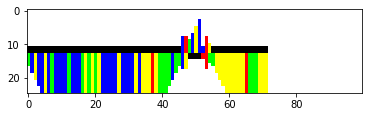

In [54]:
plt.imshow(images[0,0])

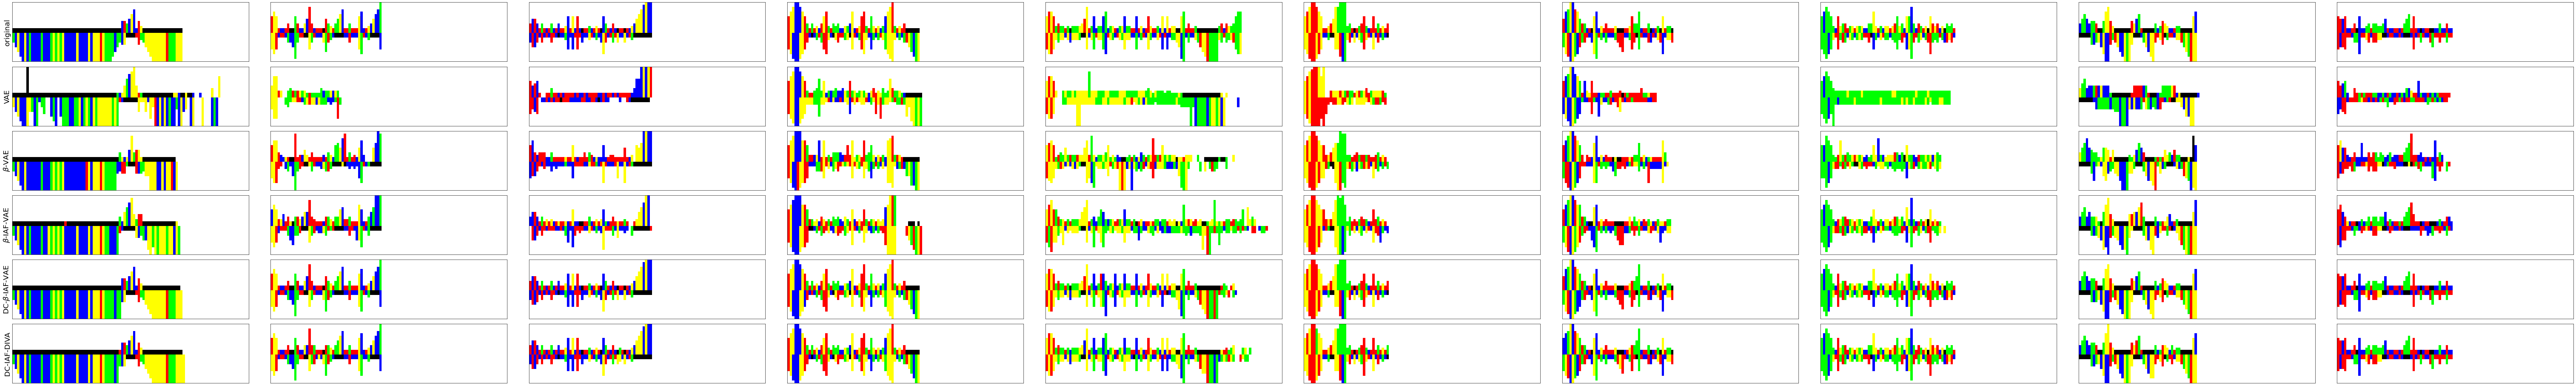

In [85]:
names = ['original', 'VAE', r"$\beta$-VAE", r"$\beta$-IAF-VAE", r"DC-$\beta$-IAF-VAE", "DC-IAF-DIVA"]
fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(100,15))
for i in range(6):
    for j in range(10):
        
        ax[i,j].imshow(images[j,i])
        ax[i,j].set_xticks([],[])
        ax[i,j].set_yticks([],[])
        if j == 0:
            ax[i,j].set_ylabel(names[i], fontsize=20)
fig.tight_layout()
fig.savefig('reconstructions.png')

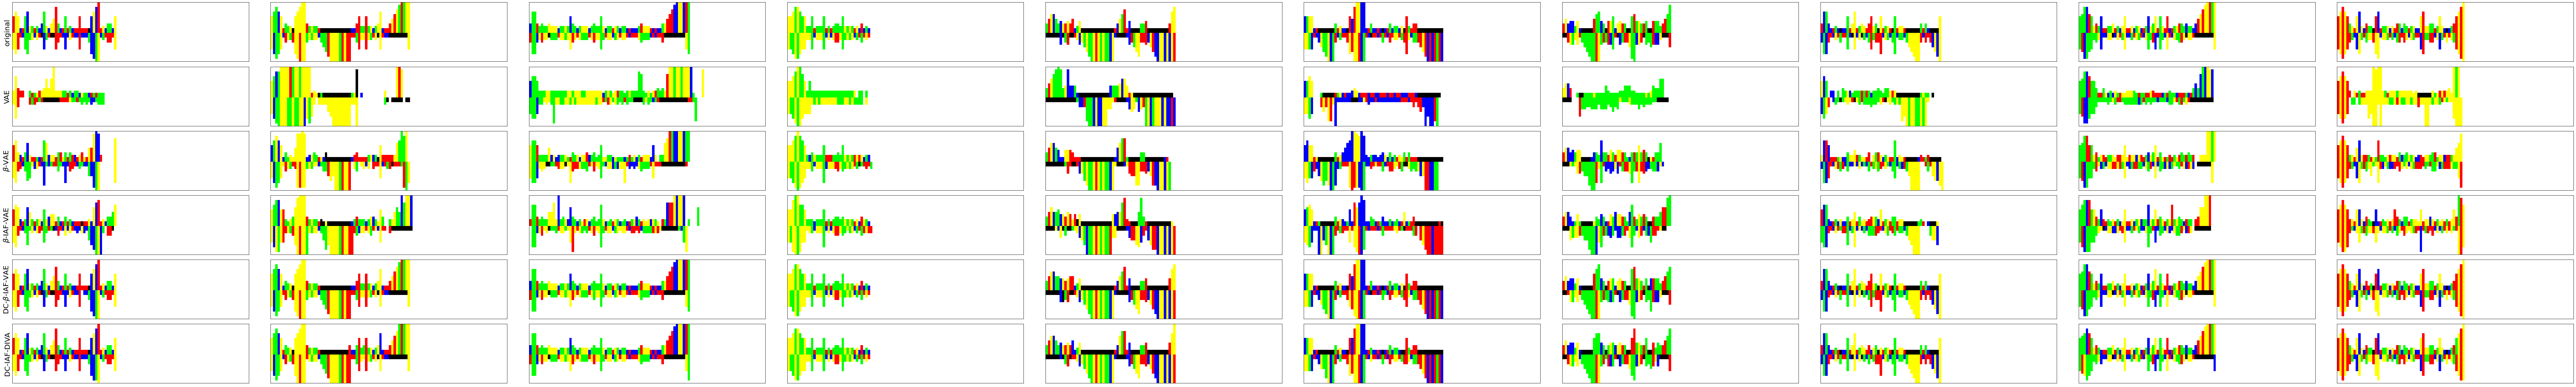

In [86]:
names = ['original', 'VAE', r"$\beta$-VAE", r"$\beta$-IAF-VAE", r"DC-$\beta$-IAF-VAE", "DC-IAF-DIVA"]
fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(100,15))
for i in range(6):
    for j in range(10):
        
        ax[i,j].imshow(images[j+10,i])
        ax[i,j].set_xticks([],[])
        ax[i,j].set_yticks([],[])
        if j == 0:
            ax[i,j].set_ylabel(names[i], fontsize=20)
fig.tight_layout()
fig.savefig('reconstructions2.png')

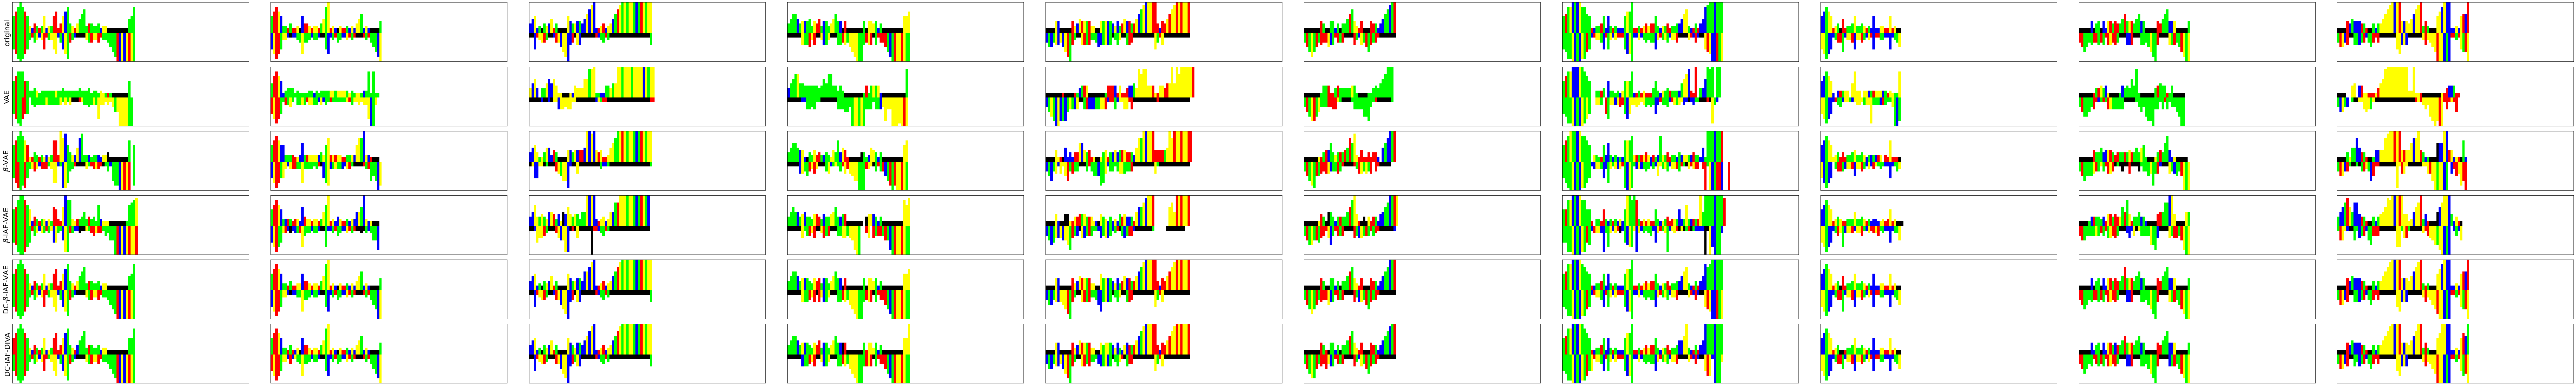

In [87]:
names = ['original', 'VAE', r"$\beta$-VAE", r"$\beta$-IAF-VAE", r"DC-$\beta$-IAF-VAE", "DC-IAF-DIVA"]
fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(100,15))
for i in range(6):
    for j in range(10):
        
        ax[i,j].imshow(images[j+20,i])
        ax[i,j].set_xticks([],[])
        ax[i,j].set_yticks([],[])
        if j == 0:
            ax[i,j].set_ylabel(names[i], fontsize=20)
fig.tight_layout()
fig.savefig('reconstructions3.png')

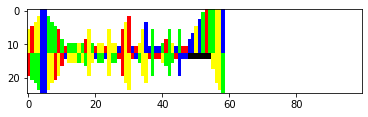

In [32]:
plt.imshow(x_org[1])

In [188]:
df = pd.DataFrame(columns = ['MAE','MAE nucleotide', 'MAE length'])
errs = np.zeros((5,25,100))
for i in range(len(models)):
    stats = {}
    z_te, x_hat_te, x_te = model_analysis(models[i], args_list[i], test_loader)
    errs[i] = 1 - (x_te == x_hat_te).prod(1).mean(0)
    stats['MAE'] = 1-(x_te==x_hat_te).prod(1).mean().round(4)
    stats['MAE nucleotide'] = 1-correct_nucleotides(x_te, x_hat_te).mean().round(4)
    stats['MAE length'] = wrong_shape(x_te, x_hat_te).mean().round(4)
    
    df.loc[names[i+1]] = stats


117batch [00:05, 22.43batch/s]
117batch [00:17,  6.74batch/s]
117batch [00:05, 19.62batch/s]
117batch [00:08, 14.44batch/s]
117batch [00:13,  8.42batch/s]


In [195]:
errs.max()

0.6394731536859082

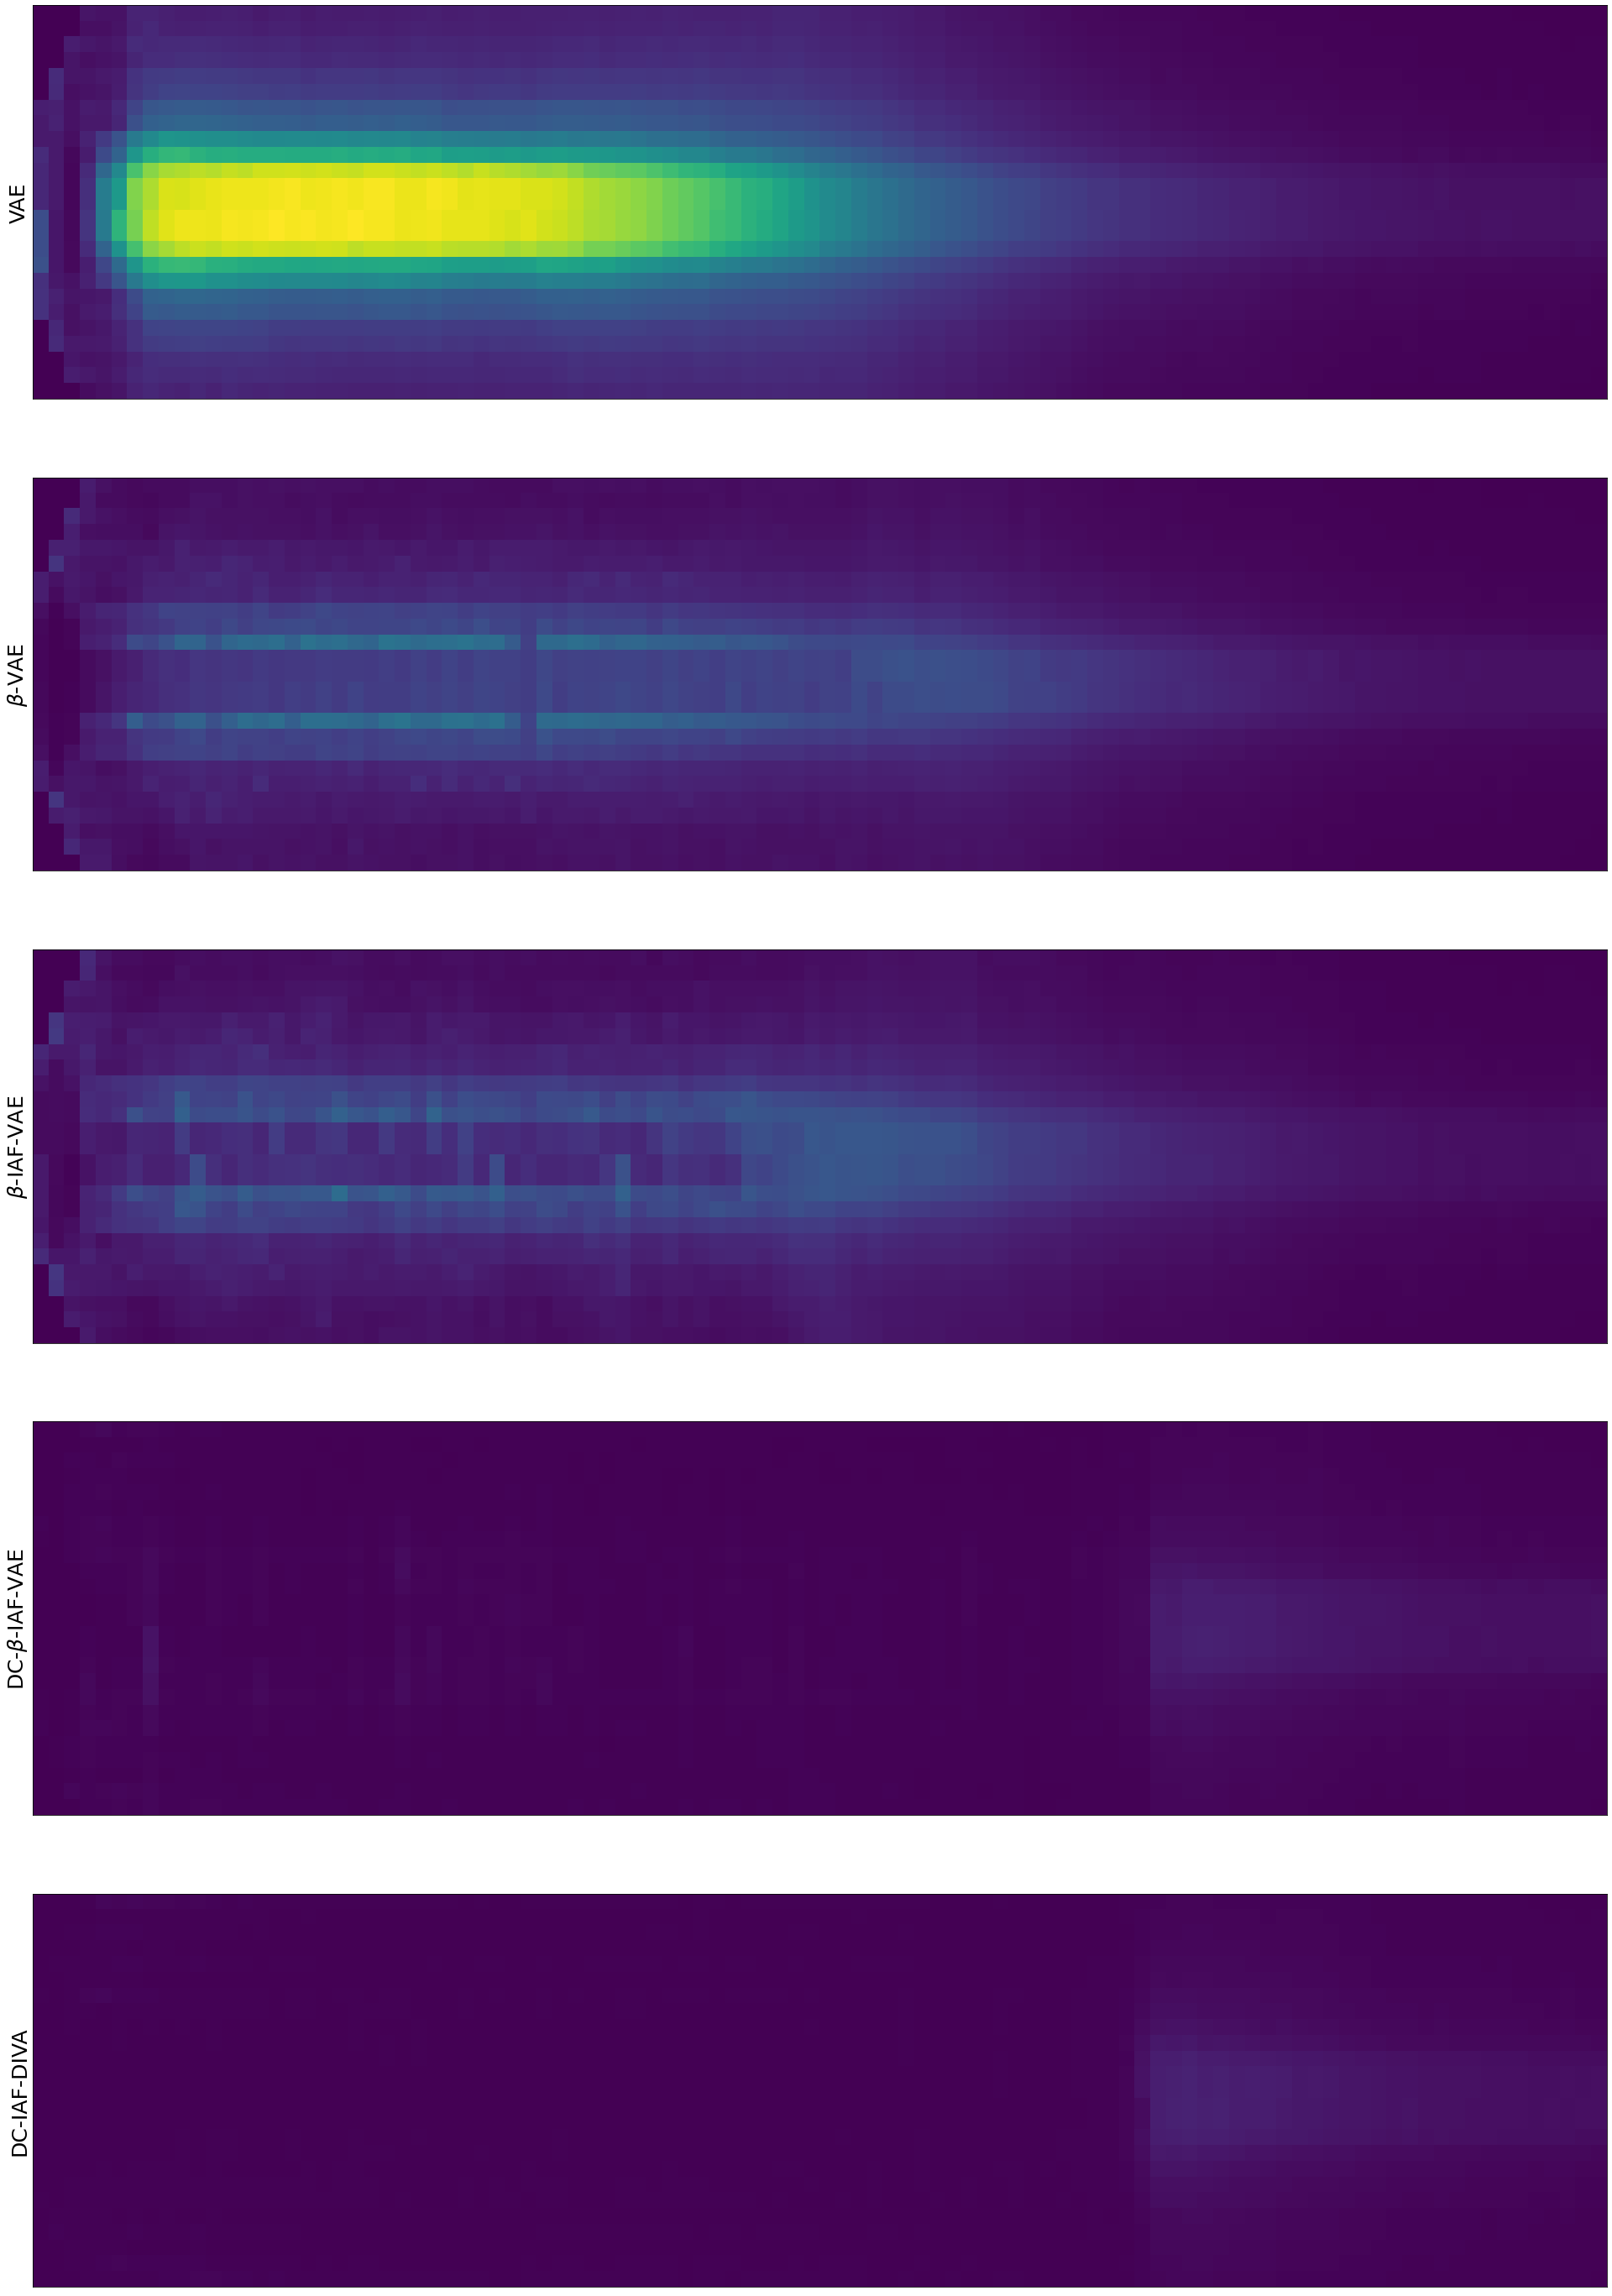

In [198]:
fig, ax = plt.subplots(nrows=5, figsize=(40,50))
for i in range(5):
    ax[i].imshow(errs[i], vmin=0, vmax=errs.max())
    ax[i].set_xticks([],[])
    ax[i].set_yticks([],[])
    ax[i].set_ylabel(names[i+1], fontsize=25)
fig.savefig('error_dist.png')

In [128]:
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &     MAE &  MAE nucleotide &  MAE length \\
\midrule
VAE                &  0.1363 &          0.3053 &      0.7844 \\
\$\textbackslash beta\$-VAE        &  0.0550 &          0.0919 &      0.4779 \\
\$\textbackslash beta\$-IAF-VAE    &  0.0531 &          0.0824 &      0.4443 \\
DC-\$\textbackslash beta\$-IAF-VAE &  0.0085 &          0.0150 &      0.0670 \\
DC-IAF-DIVA        &  0.0068 &          0.0122 &      0.0567 \\
\bottomrule
\end{tabular}



In [129]:
z_diva, x_hat_te, x_te = model_analysis(models[-1], args_list[-1], test_loader)
z_vae, x_hat_te, x_te = model_analysis(models[-2], args_list[-2], test_loader)

117batch [00:14,  8.32batch/s]
117batch [00:08, 14.52batch/s]


In [148]:
latent_space_m = TSNE(random_state=10).fit_transform(z_diva['m'])

In [149]:
latent_space = TSNE(random_state=10).fit_transform(z_vae['x'])

In [227]:
def compare_latent_space(z1, z2, c, labels, legend=True):
    fig, ax = plt.subplots(ncols=2, figsize=(50,20), sharex=True, sharey=True)
    
    sc0 = plot_latent_space(z1, c, ax[0])
    sc1 = plot_latent_space(z2, c, ax[1])
    ax[0].set_title(r'DC-IAF-DIVA $\mathbf{z}_m$ latent space', fontsize=30)
    ax[1].set_title(r'DC-$\beta$-IAF-VAE $\mathbf{z}$ latent space', fontsize=30)
    
    
    if legend:
        if labels is None:
            handles, labels = sc0.legend_elements()
        else:
            handles, _ = sc0.legend_elements()
        legend0 = ax[0].legend(handles, labels,
                        loc="upper left", fontsize=17)

        if labels is None:
            handles, labels = sc1.legend_elements()
        else:
            handles, _ = sc1.legend_elements()
        legend1 = ax[1].legend(handles, labels,
                        loc="upper left", fontsize=17)
        ax[0].add_artist(legend0)
        ax[1].add_artist(legend1)
        fig.tight_layout()
        fig.colorbar(sc1, ax=ax.ravel().tolist())
    else:
        fig.tight_layout()
        fig.colorbar(sc1, ax=ax.ravel().tolist())
    
   
    return fig
    
def plot_latent_space(z, c, ax):
    return ax.scatter(z[:,0], z[:,1], c=c, s=4)

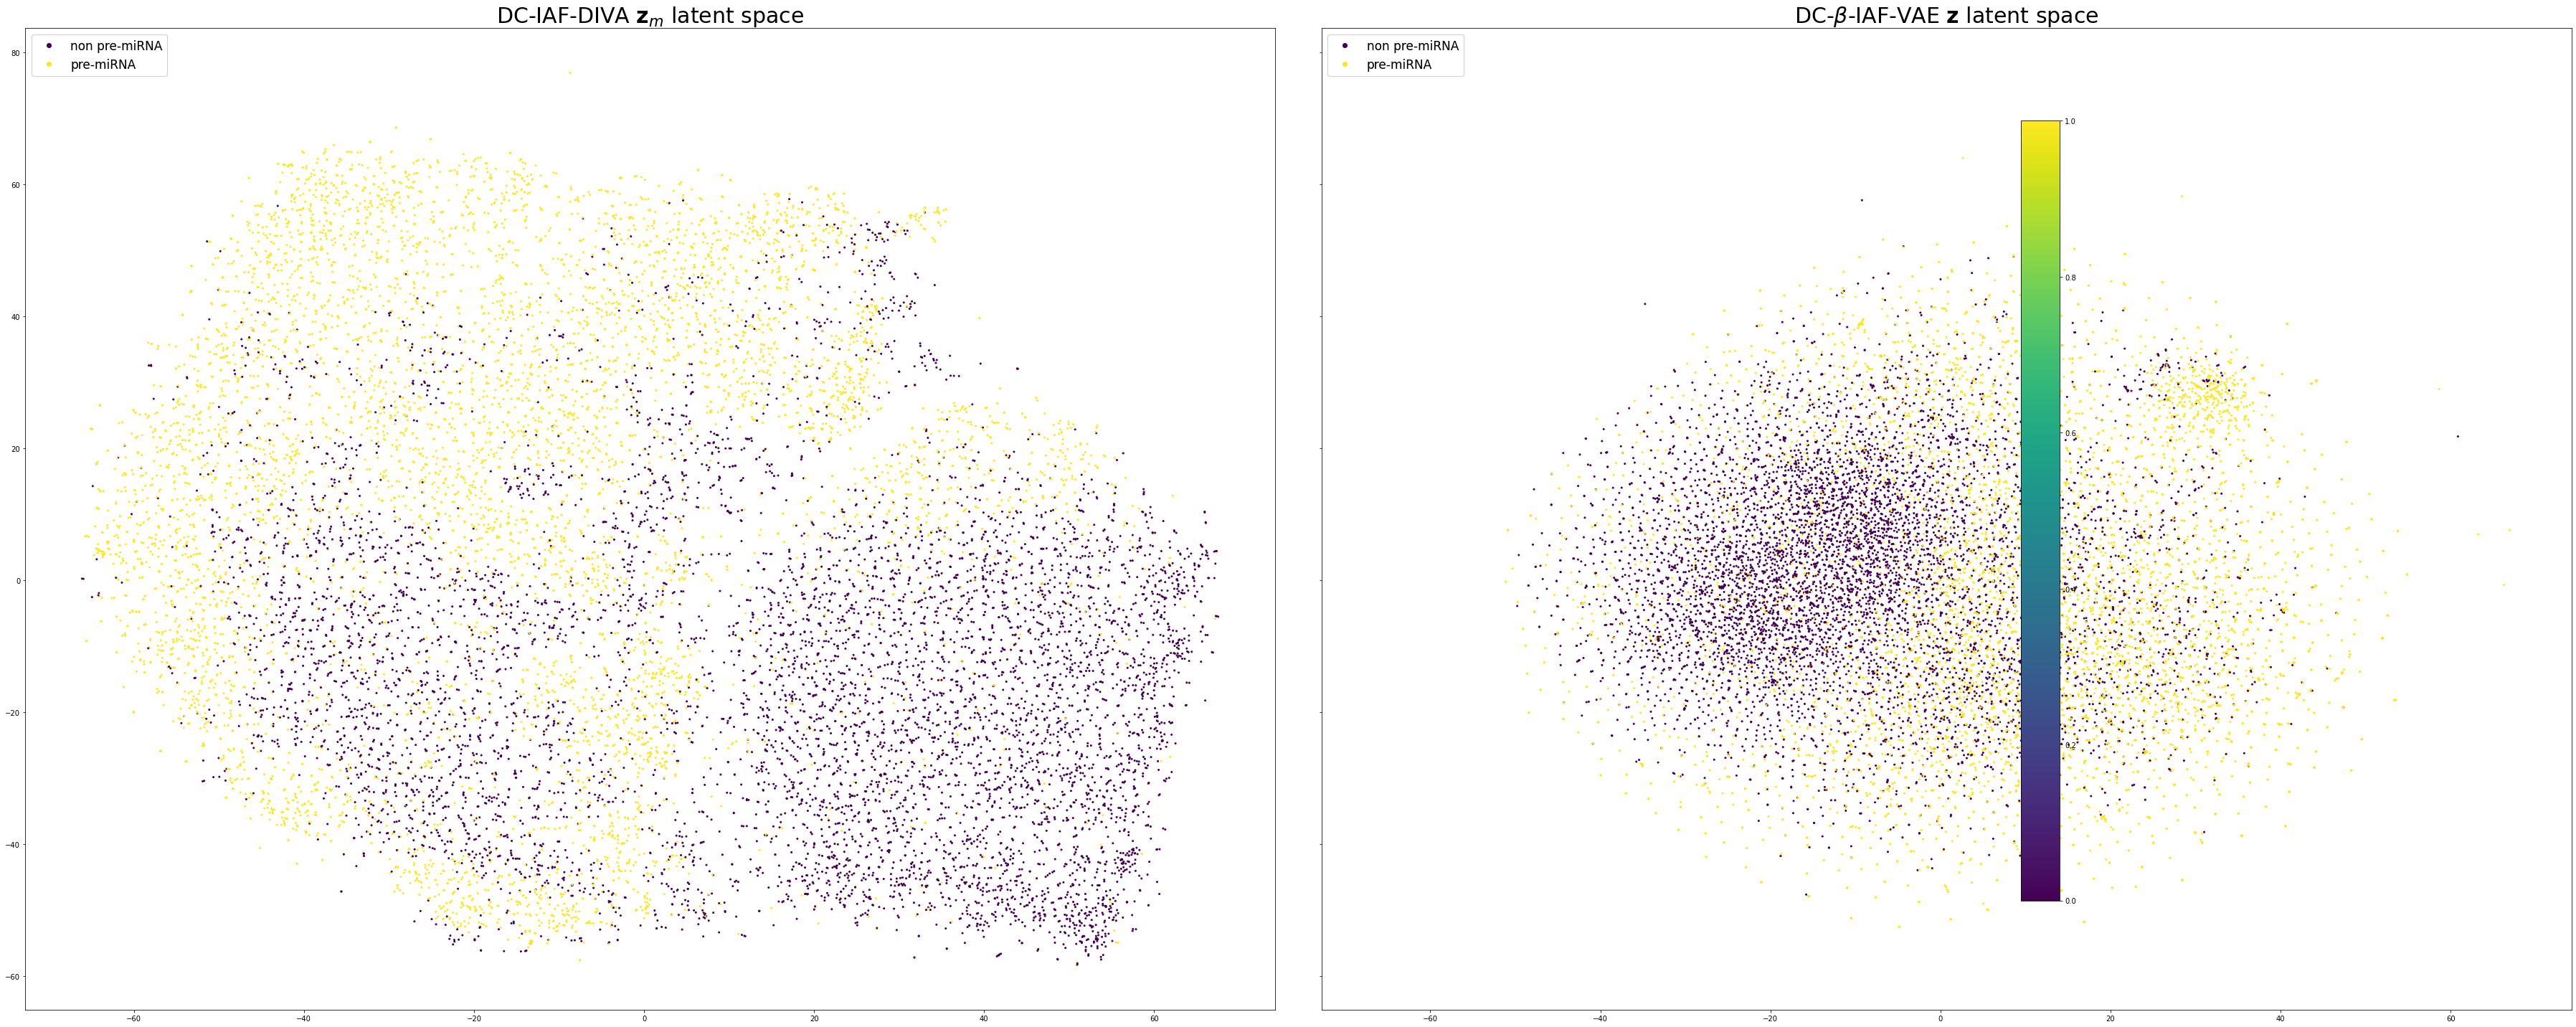

In [228]:
f = compare_latent_space(latent_space_m,latent_space,test_loader.dataset.labels.argmax(1).flatten(), ['non pre-miRNA', 'pre-miRNA'])
f.savefig('VAEvDIVA.png')

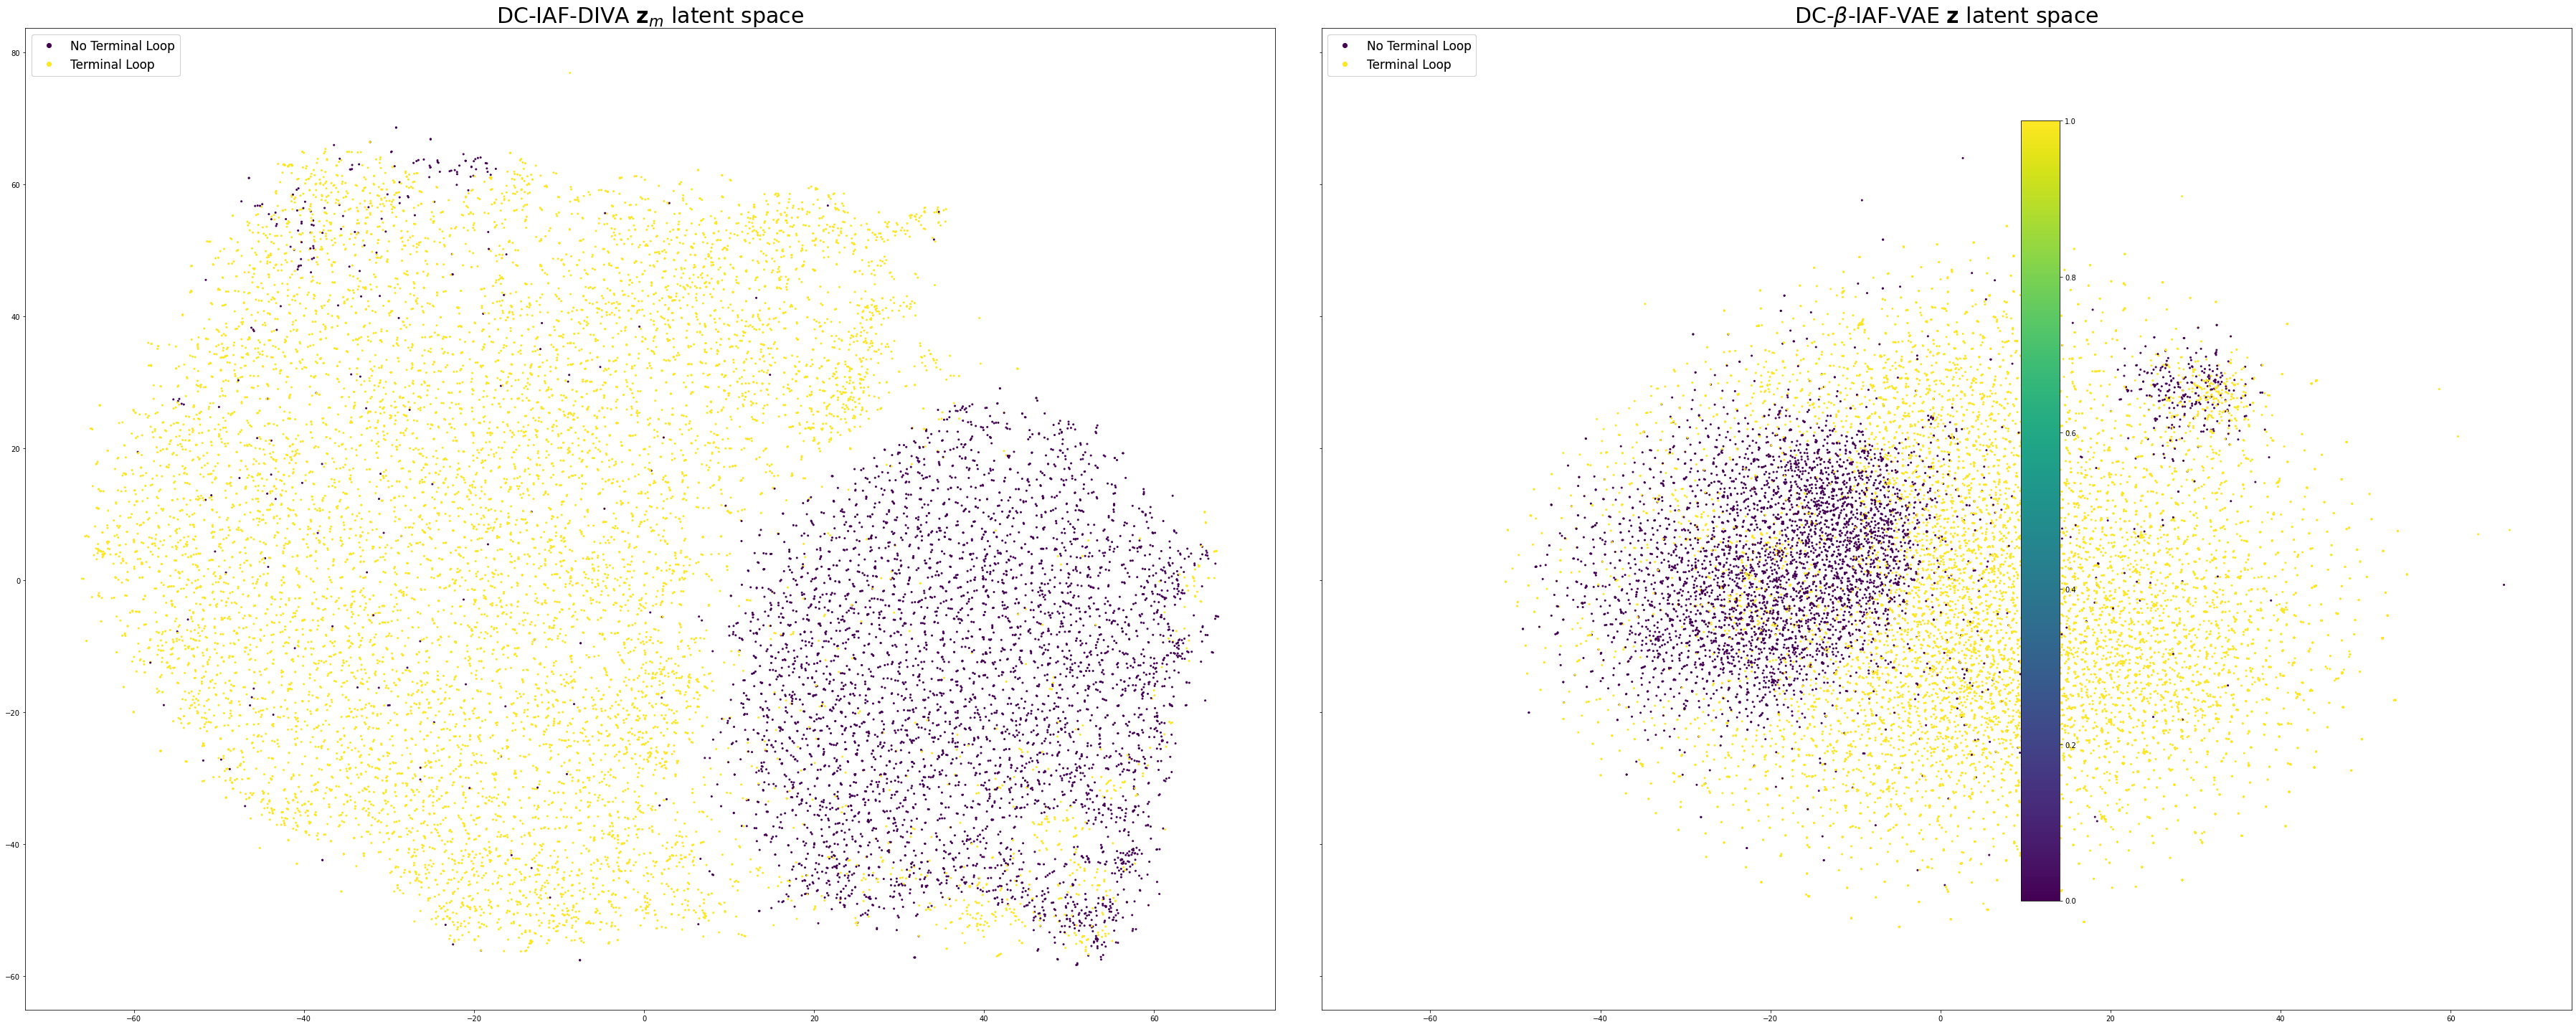

In [229]:
f = compare_latent_space(latent_space_m,latent_space,concepts_test['presence_terminal_loop'], ['No Terminal Loop', 'Terminal Loop'])
f.savefig('VAEvDIVA_terminal.png')

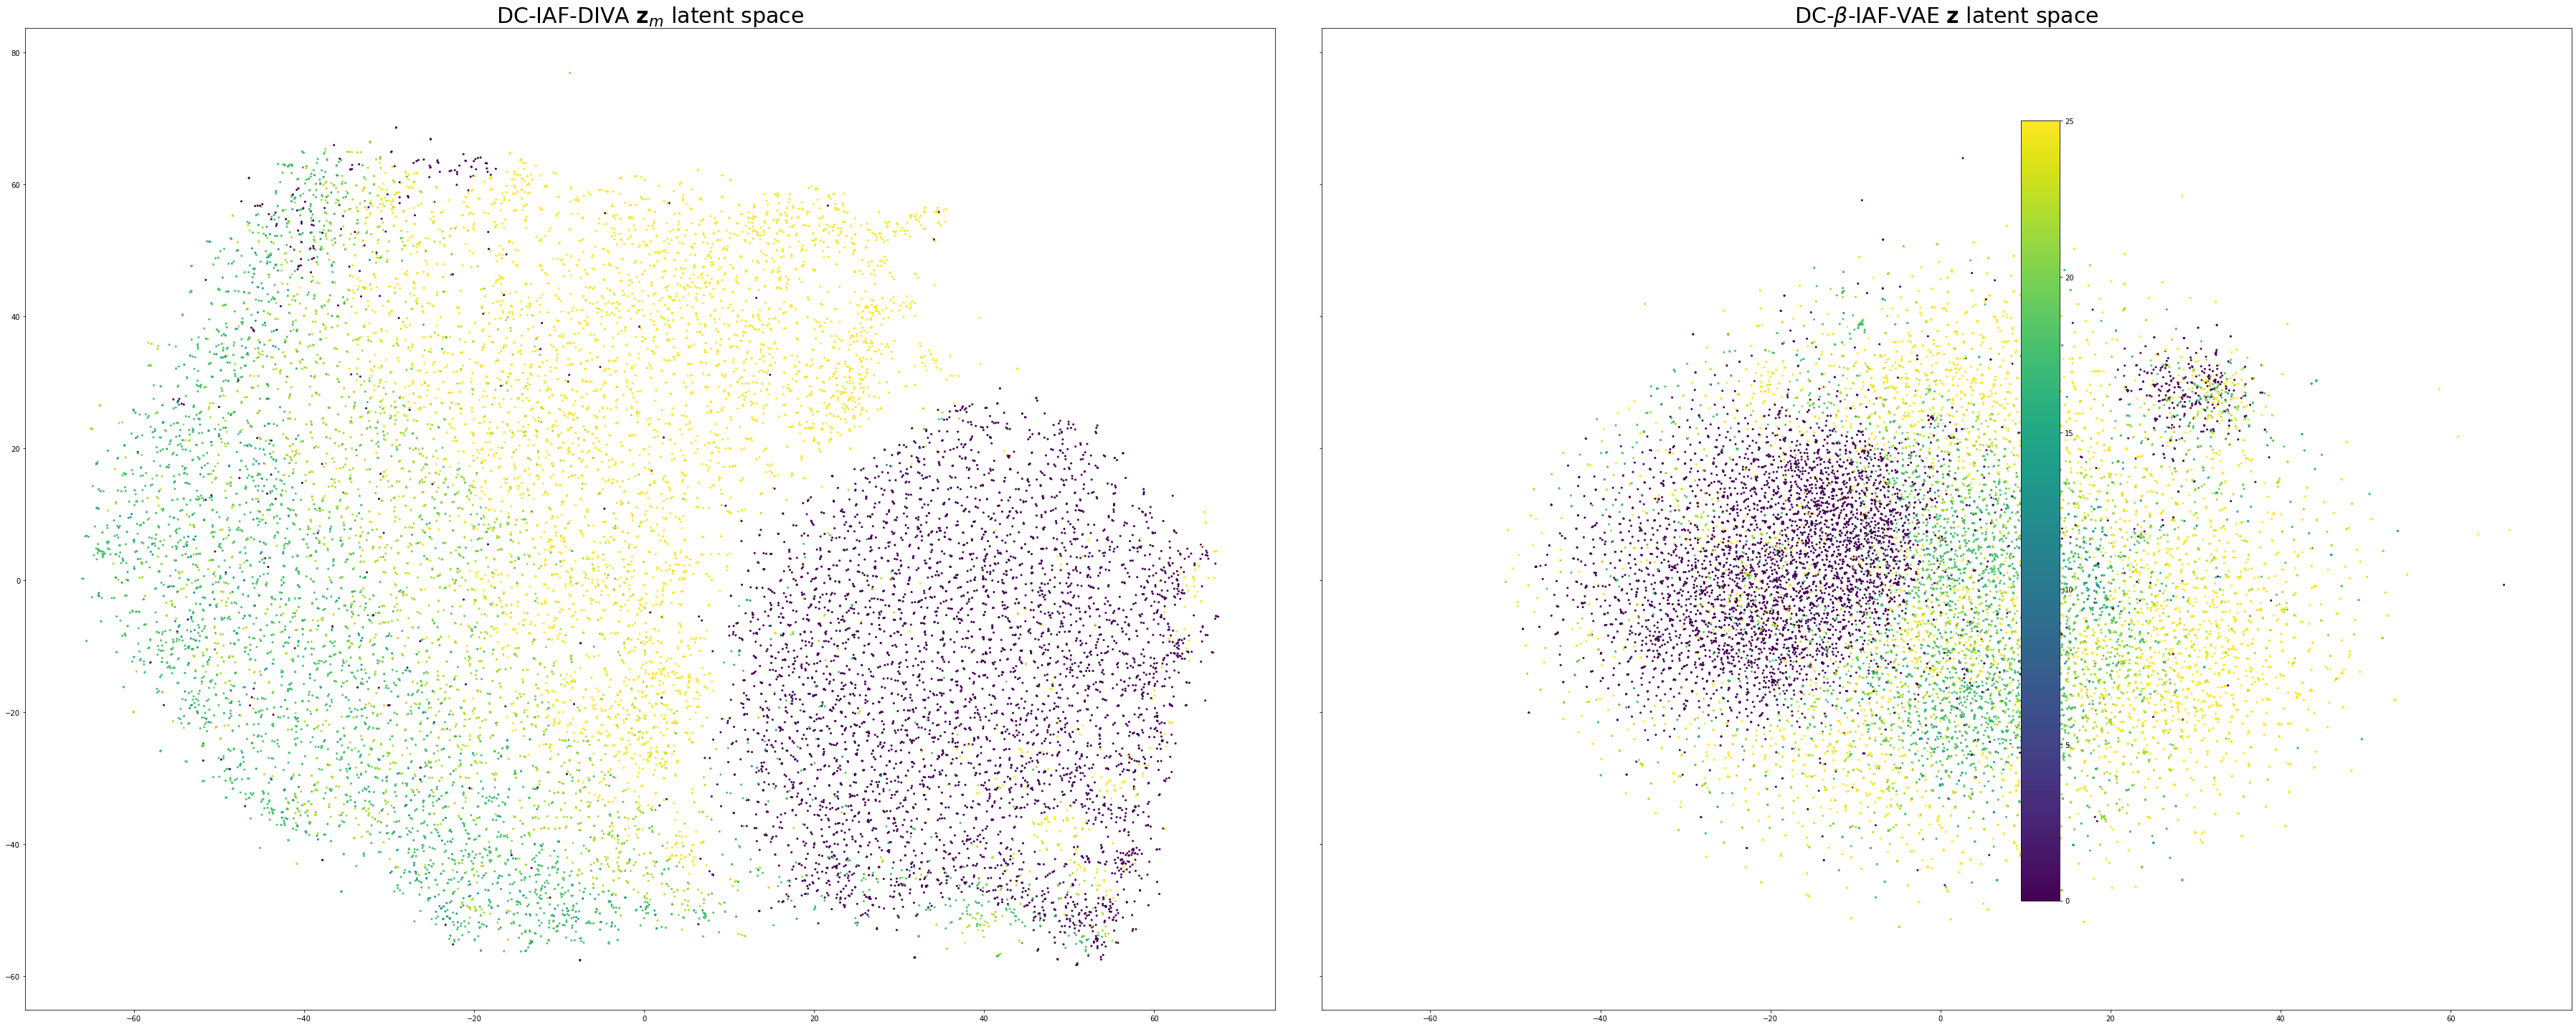

In [230]:
f = compare_latent_space(latent_space_m,latent_space,concepts_test['loop_length'], None, False)
f.savefig('VAEvDIVA_width.png')

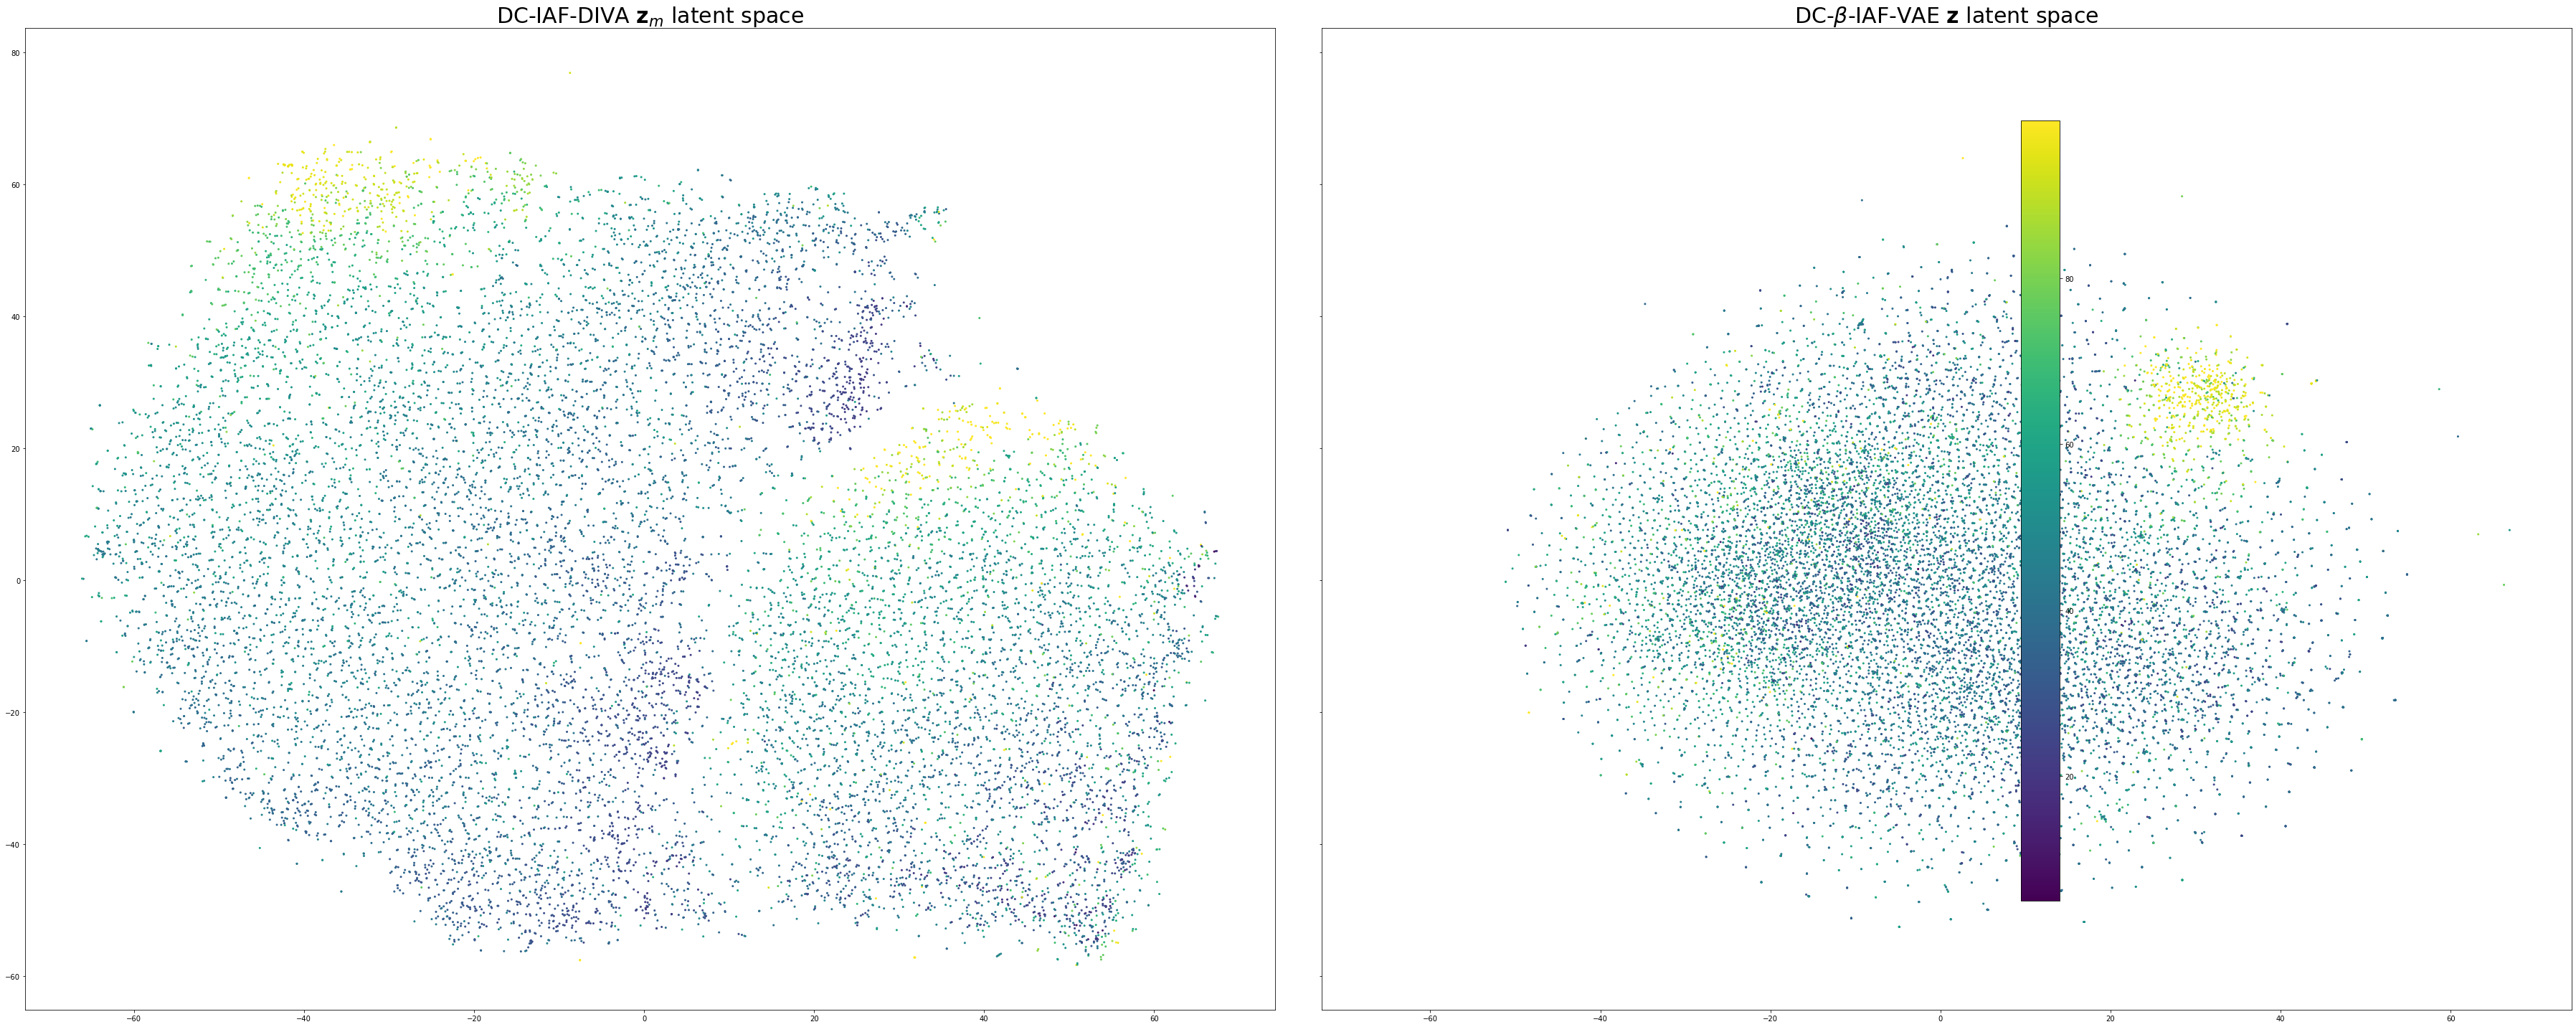

In [231]:
f = compare_latent_space(latent_space_m,latent_space,concepts_test['stem_length'],None, False)
f.savefig('VAEvDIVA_stem.png')

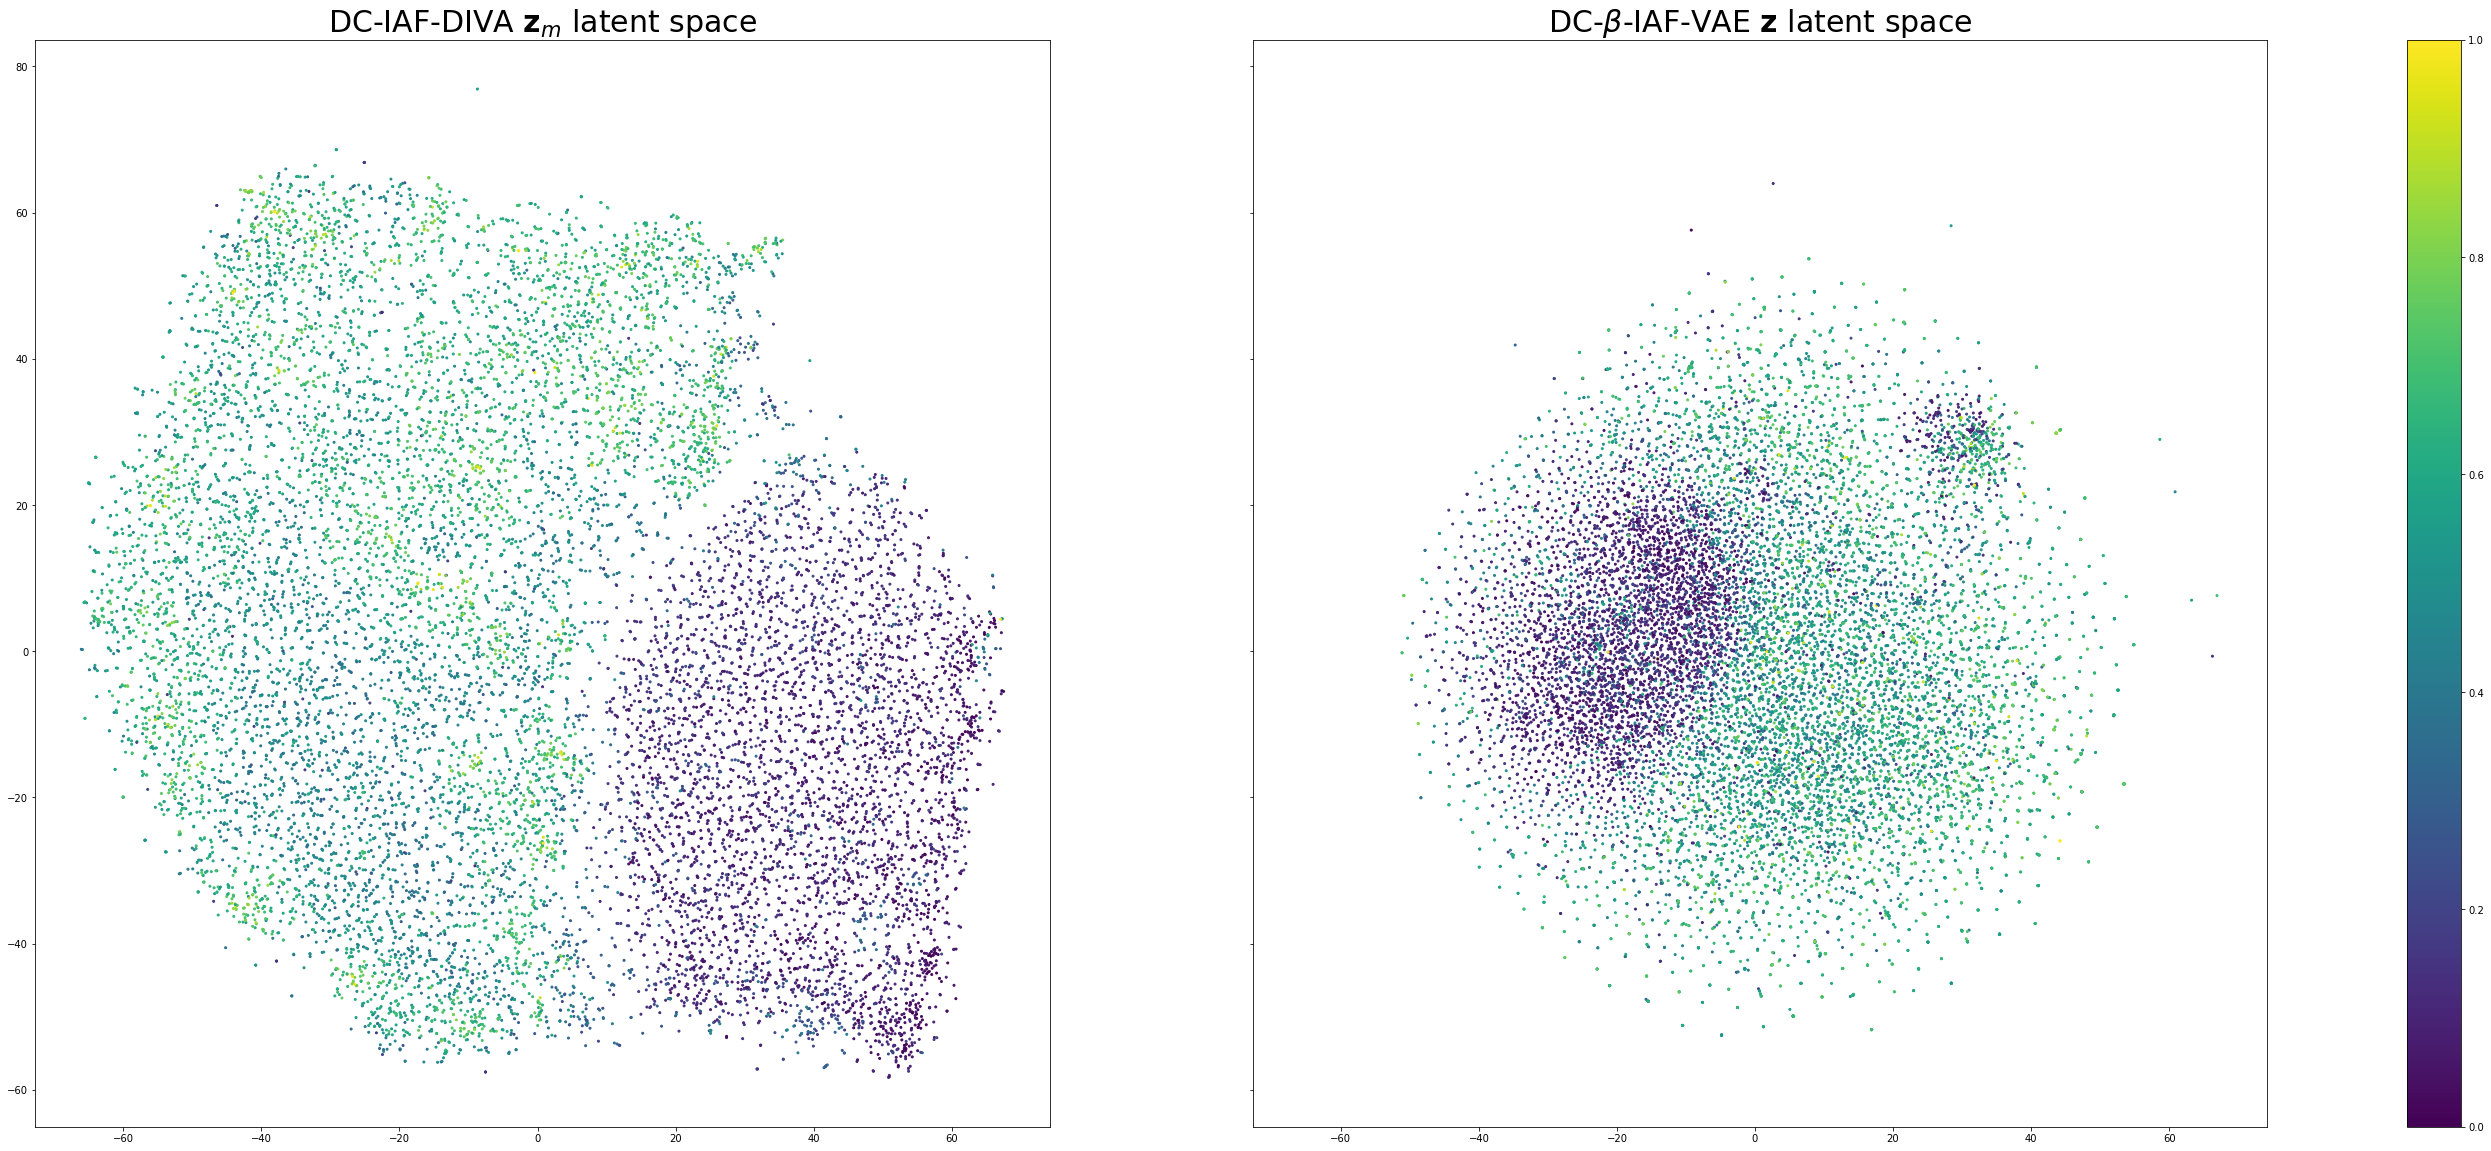

In [226]:
f = compare_latent_space(latent_space_m,latent_space,concepts_test['base_pairs_in_stem'],None, False)
f.savefig('VAEvDIVA_pairs.png')

In [178]:
for i in concepts_test.columns:
    print(i, np.unique(concepts_test[i]))

Unnamed: 0 [    0     1     2 ... 14878 14879 14880]
idx [    0     1     2 ... 14878 14879 14880]
class_label [0 1]
presence_terminal_loop [False  True]
start_loop_upperhalf_col [-1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 38. 39. 40. 41. 42. 44. 45. 47. 48. 49. 50. 59.]
highest_point_loop_upperhalf_row [-1.  0.  1.  2.  3.  4.  5.  6.  7.]
highest_point_loop_upperhalf_col [-1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 35. 36.
 37. 38. 39. 42. 44. 46. 47. 56.]
loop_length [ 0. 12. 14. 15. 16. 18. 19. 20. 22. 24. 25.]
loop_width [ 0.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37.
 39. 40. 41. 42. 43. 45. 46. 48. 49. 50. 51. 60.]
gap_start [-1.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 1

In [108]:
df = pd.DataFrame(columns=['a','b'])
df.loc['uga'] = {'a':1,'b':23}

In [109]:
df

a   b
uga  1  23

In [93]:
nuc = correct_nucleotides(x_te, x_hat_te)

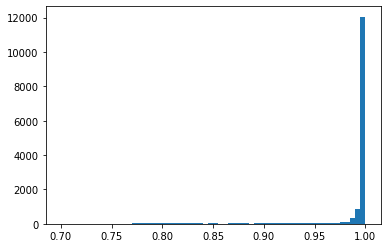

In [104]:
plt.hist(nuc.mean(axis=(1,2)), bins=np.arange(0.7,1,0.005));

In [111]:
lnt = correct_shape(x_te, x_hat_te)

In [114]:
lnt.mean()

0.9954549963901658

In [98]:
nuc.mean(axis=(1,2))

array([1., 1., 1., ..., 1., 1., 1.])

In [126]:
def calculate_error_statistics(x, x_hat):
    '''
    function which calculates all reconstruction statistics
    '''
    correct_nt = correct_nucleotides(x, x_hat)
    correct_sh = correct_shape(x, x_hat)
    correct_le = correct_length(x, x_hat)
    return correct_nt, correct_sh, correct_le
    
def correct_nucleotides(x, x_hat):
    '''
    calculates which nucleotides are correct
    '''
    return (x[:,:,12:14]==x_hat[:,:,12:14]).prod(1)

def wrong_shape(x, x_hat):
    '''
    calculates how correct the shape is
    '''
    x, x_hat = x.sum((1,)), x_hat.sum((1,))
    a = 13-(x[:,:13] == x_hat[:,:13]).sum(1)
    b = 12-(x[:,13:] == x_hat[:,13:]).sum(1)
    result = np.concatenate((a,b),axis=1)
    return result

def correct_length(x, x_hat):
    '''
    calculates which part of the length of the reconstruction is correct
    '''
    x, x_hat = x[:,:,12:13].sum(1), x_hat[:,:,12:13].sum(1) 
    return x == x_hat

In [ ]:
z_tr, x_hat_tr, x_tr = model_analysis(model, args, train_loader)
z_te, x_hat_te, x_te = model_analysis(model, args, test_loader)

In [11]:
latent_space_m = TSNE().fit_transform(z_te['m'])

In [12]:
fig = go.FigureWidget(
    data=[
        dict(
            type='scattergl',
            x=latent_space_m[:,0],
            y=latent_space_m[:,1],
            mode='markers',
            marker = dict(color=np.argmax(test_loader.dataset.labels,1),
                          size=4),
          
        )
    ],
    
    layout=dict(height=500, width=750)
)

In [13]:
def set_color(column):
    fig.data[0].marker.color = concepts_test[column]*1

In [14]:
radio = RadioButtons(options=concepts_test.columns[2:])
radiowidget = interact(set_color, column=radio)

interactive(children=(RadioButtons(description='column', options=('class_label', 'presence_terminal_loop', 'st…

In [15]:
def compress_to_bytes(data, fmt):
    """
    Helper function to compress image data via PIL/Pillow.
    """
    data = data.repeat(10, axis=0).repeat(10, axis=1)
    buff = io.BytesIO()
    img = PIL.Image.fromarray(np.uint8(data*255))    
    img.save(buff, format=fmt)
    
    return buff.getvalue()

def hover_fn(trace, points, state):

    ind = points.point_inds[0]

    
    # Update image widget
    im = compress_to_bytes(test_loader.dataset.images[ind],'png')
    image_widget.value = im
    details.value = pd.DataFrame({'name':[test_loader.dataset.names[ind]], 'class':[test_loader.dataset.labels.argmax(1)[ind]]}).to_html(col_space={'name':250,'class':50})
    
details = HTML()
details.value = pd.DataFrame({'name':[test_loader.dataset.names[0]], 'class':[test_loader.dataset.labels.argmax(1)[0]]}).to_html(col_space={'name':250,'class':50})

In [16]:
fig.data[0].on_hover(hover_fn)

In [17]:
fmt='png'
im = compress_to_bytes(test_loader.dataset.images[0],fmt)
image_widget = Image(
    value=im,
    layout=Layout(height='250px', width='1000px')
)

In [18]:
VBox([HBox([fig, 
      radio]), HBox([image_widget]), details])

    'data': [{'marker': {'color': array([0, 0, 1, ..., 1, 0, 0], …

In [19]:
from decisiontree import Tree

In [20]:

thresholds = {'start_loop_upperhalf_col':[3,7,15,30,45],
              'highest_point_loop_upperhalf_col':[3,7,9,15,30,45],
              'gap_start':[2,8,20,40],
              'palindrome_score':[.25,.5,.6,.7,.8,.9],
              'large_asymmetric_bulge':[2,4,8,10,20,40,60],
              'largest_asym_bulge_sequence_location':[5,20,40,60,80],
              'stem_begin':[15,35,45,55,60,75],
              'stem_end':[3,5,8,12,20,30,40],
              'stem_length':[10,20,30,35,40,45,50,55,60,70,80,90],
              'total_length':[20,30,40,50,60,70,80,90],
              'base_pairs_in_stem':[.1,.3,.5,.7,.9],
              'base_pairs_wobbles_in_stem':[.1,.3,.5,.7,.9],
              'loop_width':[2,8,20,45],
              
              }

In [21]:
dtc = Tree(thresholds, max_depth=5, cls=LinearSVC,
           cls_args=dict(dual=False))

In [22]:
dtc.fit(z_tr['m'], train_loader.dataset.labels.argmax(1).flatten(), concepts_train[concepts_train.columns[3:]], prune=True)

In [23]:
dtc.score(z_tr['m'], train_loader.dataset.labels.argmax(1).flatten())

0.9453644768295844

In [24]:
dtc.score(z_te['m'], test_loader.dataset.labels.argmax(1).flatten())

0.9143202741751226

In [25]:
g = dtc.plot_tree()
g.render('dtc_new_', format='png')

'dtc_new_.png'

In [26]:
def plot_latent_space(z, c):
    plt.scatter(z[:,0], z[:,1], c=c, s=.1)

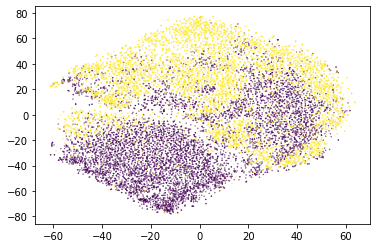

In [27]:
plot_latent_space(latent_space_m,test_loader.dataset.labels.argmax(1).flatten())

In [29]:
nt, sh, le = calculate_error_statistics(test_loader.dataset.images_cat, x_hat_te)

In [30]:
nt.mean()

0.9957745447214569

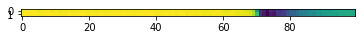

In [31]:
plt.imshow(nt.prod(axis=1).mean(0))

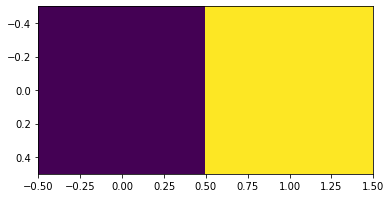

In [32]:
plt.imshow([[0,1]])

In [ ]:
nt.mean()

In [71]:
np.prod([True,False])

0

In [12]:
err = 1 - (x_te ==  x_hat_te).prod(1)

In [13]:
err.max()

1

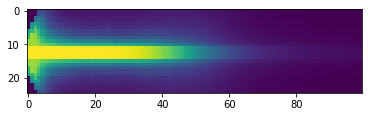

In [22]:
plt.imshow(x_te.sum(1).mean(0))

In [30]:
err.sum(0).max()

917

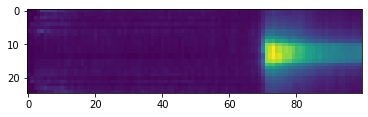

In [29]:
plt.imshow(err.sum(0))

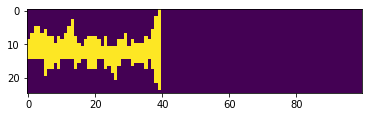

In [16]:
plt.imshow(x_te[1].sum(0))

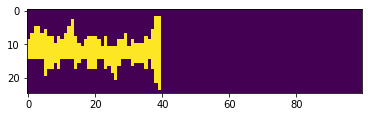

In [17]:
plt.imshow(x_hat_te[1].sum(0))

In [32]:
torch.nn.functional.one_hot(torch.tensor([[1,2,3,4]])).argmax(2)

tensor([[1, 2, 3, 4]])

In [39]:
concepts_test[concepts_test.columns[3:]]['presence_terminal_loop']*1.0

0        1.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
14876    1.0
14877    0.0
14878    1.0
14879    0.0
14880    0.0
Name: presence_terminal_loop, Length: 14881, dtype: float64

In [42]:
np.corrcoef([1,2,3],[2,3,4])

array([[1., 1.],
       [1., 1.]])

In [45]:
z_tr['m'].shape

(34721, 64)

In [61]:
def get_top_cor(col, z, top = 4):
    cor = np.zeros((z.shape[1],))
    
    for i in range(z.shape[1]):
        cor[i] = spearmanr(z[:,i], col)[0]
    
    cor_abs = np.abs(cor)
    idx = np.argsort(cor_abs)[::-1][:top]
    
    return cor[idx], idx

In [62]:
for i in concepts_test.columns[3:]:
    c, idx = get_top_cor(concepts_test[i]*1.0, zm)
    print(f'{i}: {c} {idx}')

presence_terminal_loop: [-0.54687578 -0.50568814 -0.45718716  0.45261115] [15 10  9 34]
start_loop_upperhalf_col: [-0.65116231 -0.52158547 -0.50579834 -0.4633974 ] [27 39 10 21]
highest_point_loop_upperhalf_row: [-0.6620911  -0.50639063 -0.48075549  0.47229618] [15 17 42 35]
highest_point_loop_upperhalf_col: [-0.64572885 -0.52348993 -0.50901481 -0.46551387] [27 39 10 21]
loop_length: [-0.64187847 -0.51660843 -0.50713847 -0.41934945] [27 10 39 21]
loop_width: [-0.65116231 -0.52158547 -0.50579834 -0.4633974 ] [27 39 10 21]
gap_start: [ 0.56781736  0.48840642  0.45208274 -0.4488866 ] [15 10  9 34]
palindrome_score: [-0.63248715 -0.62971146  0.56356037  0.52986915] [10  9 34 51]
asymmetric: [ 0.46174392  0.45604996  0.43211848 -0.41560638] [ 9 15 10 34]
large_asymmetric_bulge: [ 0.46340681  0.45254556  0.43460824 -0.39885986] [ 9 15 10 34]
largest_asym_bulge_strand_location: [ 0.25868761  0.25235021  0.24705214 -0.23442684] [15  9 10 34]
largest_asym_bulge_sequence_location: [ 0.32660371  

In [53]:
zm = z_te['m']
for i in range(z_te['m'].shape[1]):
    print(f'{i} {pearsonr(zm[:,i], concepts_test[concepts_test.columns[3:]].presence_terminal_loop*1.0)[0]}')

0 0.14011964418587936
1 -0.027015324318706783
2 0.1991583660723179
3 -0.1049297130229704
4 0.19832440820562253
5 0.13287836359825936
6 0.23466439947330586
7 0.06334974325076338
8 0.11674723201531483
9 -0.4452833409510196
10 -0.49608752979514387
11 -0.36696632878720475
12 0.05617992704115656
13 -0.21357974586073614
14 -0.059297594591091296
15 -0.5293271054006033
16 -0.10842481273624902
17 -0.14224310932137238
18 -0.033417921989922314
19 -0.014186637399854735
20 0.004550212165171738
21 -0.24378098776032134
22 0.054195609586182504
23 -0.33691611951137923
24 0.1258934180680727
25 0.2398785066049379
26 0.07796792355533294
27 -0.4389409531723619
28 0.030841717516145298
29 0.12956302422331903
30 0.003635947117515877
31 0.0809915116192387
32 0.14813465536844542
33 -0.0004301033636026912
34 0.4520972377860495
35 0.3125245503842604
36 0.04955017393051441
37 0.19405270375429307
38 0.13333841816924402
39 -0.30401115862723893
40 0.08990965571294034
41 0.1646053626676956
42 -0.254237682789763
43 0.0

In [51]:
zm[:,i].shape, (concepts_test[concepts_test.columns[3:]].presence_terminal_loop*1.0).shape

((34721,), (14881,))